hirf is NONE
t_domain is None
Fourier coding K=4
MAE TruncatedFourier: 371.865 mm 
MAE coded_model: 592.142 mm 
MAE coded_model: 1117.281 mm 
MAE coded_model-v8: 341.834 mm 


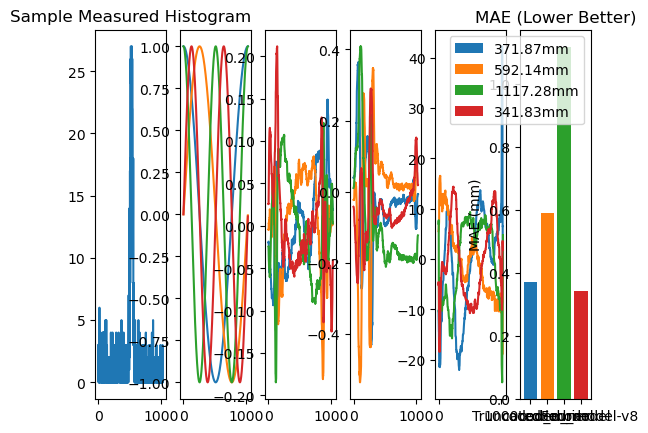

hello world


In [1]:
import numpy as np
from models.CM1DLayers import CodingLayer, ZNCCLayer
from dataset.dataset import SampleDataset
from utils.torch_utils import *

import matplotlib.pyplot as plt
import matplotlib
#
if_plot = True

rep_freq = 5 * 1e6
rep_tau = 1. / rep_freq
sigma = 30
#counts = torch.linspace(10 ** 2, 10 ** 6, 20)
#sbr = torch.linspace(0.1, 10.0, 20)
counts = torch.Tensor([10 ** 3] * 10)
sbr = torch.Tensor([1.0] * 10)
n_tbins = 1024
k = 4


#init = 'checkpoints/good_checkpoints/coded_model-v9.ckpt'
inits = ['TruncatedFourier', 'experiments/code_models/version_0/checkpoints/coded_model.ckpt',
         'experiments/code_models/version_4/checkpoints/coded_model.ckpt', 'checkpoints/good_checkpoints/coded_model-v8.ckpt']

sample_data = SampleDataset(n_tbins, counts, sbr, num_samples=1024, sigma=sigma)
num_samples = len(sample_data)
sample = sample_data.noisy_data

gt_depths = sample_data.simulated_data.argmax(dim=-2).squeeze(-1)
gt_depths = bin2depth(gt_depths, num_bins=n_tbins, tau=rep_tau)

if if_plot:
    fig, axs = plt.subplots(1, len(inits) + 2)
    axs[0].plot(sample.__getitem__(np.random.randint(0, num_samples)), label='Noisy Pulse')
    axs[0].set_title('Sample Measured Histogram')
counter = 1
labels = []
for init in inits:
    if init.endswith('.ckpt'): get_from_model = True
    else: get_from_model = False
    coding_mat = CodingLayer(k=k, n_tbins=n_tbins, init=init, get_from_model=get_from_model)
    zncc_layer = ZNCCLayer()

    c_vals = coding_mat(sample)

    pred_depths = zncc_layer(c_vals, coding_mat.cmat1D.weight.data.detach().clone())

    pred_depths = bin2depth(pred_depths, num_bins=n_tbins, tau=rep_tau)

    loss = torch.mean(torch.abs(pred_depths.squeeze() - gt_depths.squeeze()))
    #loss = criterion_RMSE(pred_depths, gt_depths)

    print(f'MAE {init.split('/')[-1].split('.')[0]}: {loss * 1000:.3f} mm ')
    labels.append(init.split('/')[-1].split('.')[0])
    if if_plot:
        cmat = coding_mat.cmat1D.weight
        cmat = np.transpose(cmat.detach().numpy().squeeze())
        axs[counter].plot(cmat)
        #axs[counter].set_title(init.split('/')[-1].split('.')[0])

        axs[-1].bar(counter-1, loss, label=f'{loss * 1000:.2f}mm')
        axs[-1].set_title('MAE (Lower Better)')
        axs[-1].set_ylabel('MAE (mm)')
    counter += 1

axs[-1].set_xticks(np.arange(0, len(inits)))
axs[-1].set_xticklabels(labels)
axs[-1].legend()

plt.show(block=True)
print('hello world')

